In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_curve

In [13]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, learn_rate=0.001, n_iters=500):
        if len(X_train.shape) == 1:
            self.X_train = np.hstack((np.array([1]), X_train))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train

        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.array([1]), X_test))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        self.y_test = y_test

        self.learn_rate = learn_rate
        self.n_iters = n_iters 

        # Initialize model weights
        self.weight = np.zeros((self.X_train.shape[1]))

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        # Todo: Compute and return the predicted probability of each sample having an income >= 50K
        z = np.dot(samples, self.weight)
        return 1/(1+ np.exp(-z))

    def compute_gradient(self, ):
        # Todo: compute and return gradient of the average log likelihood on the training set
        predictions = self.predict_prob(self.X_train)
        n = len(self.y_train)
        return np.dot(self.X_train.T, (self.y_train - predictions)) / n

    def gradient_ascent(self, ):
        # Todo: Run gradient ascent to learn model weights
        # Todo: Store the average log likelihood and the prediction accuracy 
        #       on the training and test sets after every gradient ascent iteration
        for i in range(self.n_iters):
            gradient = self.compute_gradient()
            self.weight = self.weight + self.learn_rate * gradient

            p_train = self.predict_prob(self.X_train)
            p_test = self.predict_prob(self.X_test)
            
            # Average log-likelihood: (1/n) * sum(y*log(p) + (1-y)*log(1-p))
            ll_train = np.mean(self.y_train * np.log(p_train) + (1 - self.y_train) * np.log(1 - p_train))
            ll_test = np.mean(self.y_test * np.log(p_test) + (1 - self.y_test) * np.log(1 - p_test))
            
            self.log_likelihood_train.append(ll_train)
            self.log_likelihood_test.append(ll_test)
            
            # Compute and store accuracy
            pred_train = self.predict(self.X_train)
            pred_test = self.predict(self.X_test)
            
            acc_train = np.mean(pred_train == self.y_train)
            acc_test = np.mean(pred_test == self.y_test)
            
            self.accuracy_train.append(acc_train)
            self.accuracy_test.append(acc_test)
        

In [14]:
def preprocess_data(X_train, X_test):
    # Todo: encode categorical features using OneHotEncoder
    # Todo: standardize numerical features using StandardScaler()
    # Todo: return processed training and test sets

    #get the numeric and categorial columns
    numeric_cols = X_train.select_dtypes(include=[int, float]).columns
    categorical_cols = X_train.select_dtypes(include='object').columns

    #scale 
    scaler = StandardScaler()
    X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
    X_test_numeric = scaler.transform(X_test[numeric_cols])

    #encode categorical features
    encoder = OneHotEncoder(sparse_output=False)
    X_train_categorical = encoder.fit_transform(X_train[categorical_cols])
    X_test_categorical = encoder.transform(X_test[categorical_cols])

    #combine
    X_train_processed = np.hstack([X_train_numeric, X_train_categorical])
    X_test_processed = np.hstack([X_test_numeric, X_test_categorical])

    return X_train_processed, X_test_processed
    


In [15]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test):
    # Todo: plot the average log likelihood curves of the training and test sets
    #      during training process
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_likelihood_train, label='training logL')
    plt.plot(log_likelihood_test, label='test logL')
    plt.xlabel('Iterations')
    plt.ylabel('Average Log Likelihood')
    plt.title('Training performance')
    plt.legend(loc='lower right')
    plt.show()
    

In [16]:
def plot_accuracy_performance(accuracy_train, accuracy_test):
    # Todo: plot the prediction accuracy curves of the training and test sets
    #      during the training process
    plt.figure(figsize=(10, 6))
    plt.plot(accuracy_train, label='training accuracy')
    plt.plot(accuracy_test, label='test accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Training performance')
    plt.legend(loc='lower right')
    plt.show()

In [17]:
def plot_roc(X_train, y_train, X_test , y_test, learner):
    # Todo: plot the ROC curves 

    p_train = learner.predict_prob(learner.X_train)
    p_test = learner.predict_prob(learner.X_test)

    #getting the ROC curve
    fpr_train, tpr_train, not_needed_train = roc_curve(y_train, p_train)
    fpr_test, tpr_test, not_needed_test = roc_curve(y_test, p_test)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']

In [10]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']

In [19]:
# Preprocessing data
processed_X_train, processed_X_test = preprocess_data(X_train, X_test)

In [20]:
# Run gradient ascent with Logistic Regression
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values,
                                 n_iters=250, learn_rate=0.75)
learner.gradient_ascent()

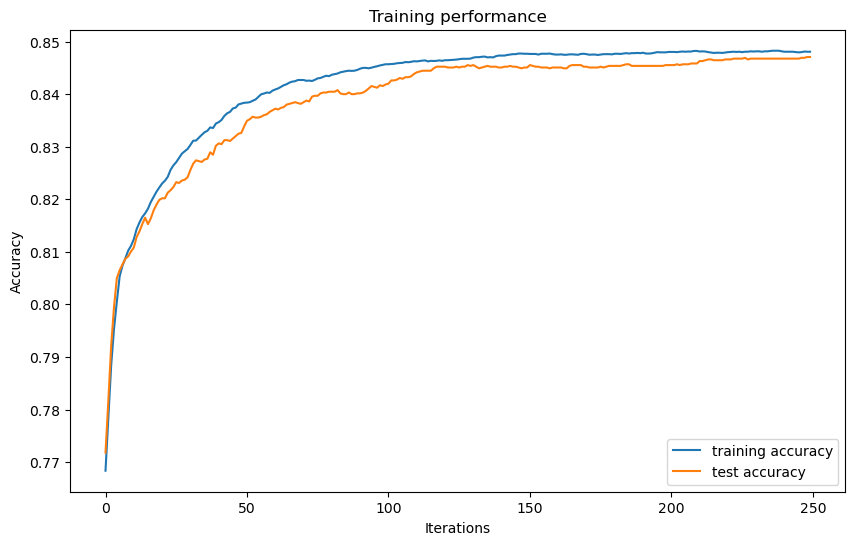

In [21]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test)

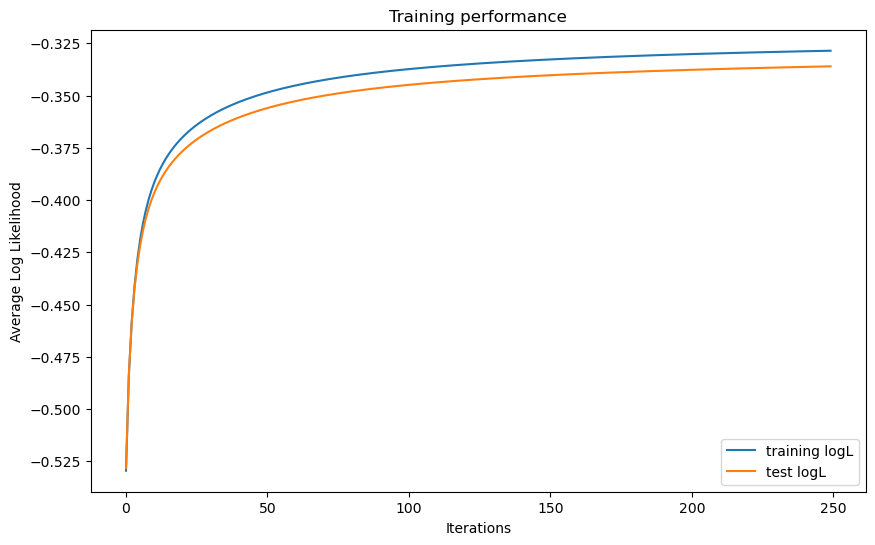

In [22]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test)

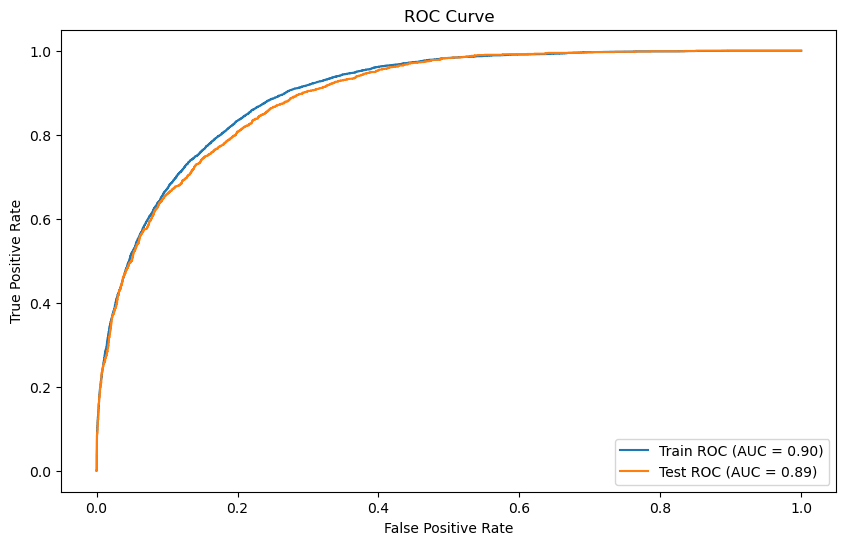

In [23]:
# Plot ROC curves
plot_roc(processed_X_train, y_train, processed_X_test, y_test, learner)